## Childhood lead poisoning in NYS and NYC
6% for scenario 1 expanded.

3% for scenario 2 simple mean.

In [3]:
%%capture
!pip install geopandas
!pip install earthpy

In [4]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

In [5]:
 # Scenario 1: Took every year for all the data
raw_data = pd.read_csv('Compiled_NY_data_expanded.csv') #importing dataset with training and testing data
threshold = 0.06

# Scenario 2: Simple mean of the data
#raw_data = pd.read_csv('/content/drive/MyDrive/Data_Mining_Analytics/Data Mining Final Project/Compiled_NY_data_simplemean.csv') #importing dataset with training and testing data
#threshold = 0.03

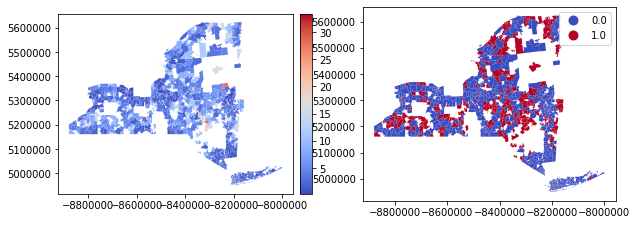

In [6]:
#Visualizing raw data
###  #Can ignore if just working on regression stuff
from shapely import wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable

raw_data['geometry'] = raw_data['geometry'].apply(wkt.loads)
raw_gdf = gpd.GeoDataFrame(raw_data, geometry=raw_data['geometry'], columns=raw_data.columns)
fig, (ax1, ax2) = plt.subplots(figsize = (10,10), ncols=2)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
raw_gdf.plot(ax=ax1, column='Percent', legend=True, cmap='coolwarm', figsize=(5, 5), cax=cax);
raw_gdf.plot(ax=ax2,column='label', legend=True, categorical=True, cmap='coolwarm', figsize=(5, 5));

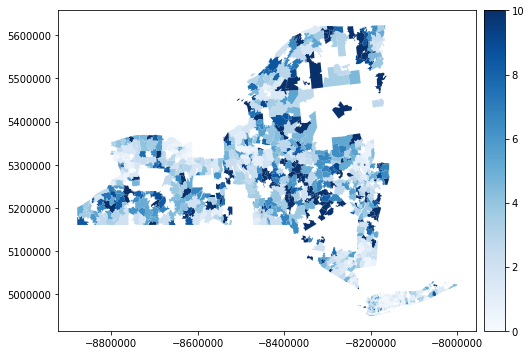

In [9]:
#Visualizing raw data
###  #Can ignore if just working on regression stuff
from shapely import wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable

 # Scenario 1: Took every year for all the data
raw_data = pd.read_csv('Compiled_NY_data_expanded.csv') #importing dataset with training and testing data
threshold = 0.06

raw_data['geometry'] = raw_data['geometry'].apply(wkt.loads)
raw_gdf = gpd.GeoDataFrame(raw_data, geometry=raw_data['geometry'], columns=raw_data.columns)
fig, (ax1) = plt.subplots(figsize = (8,8), ncols=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
raw_gdf.plot(ax=ax1, column='Percent', legend=True, cmap='Blues', figsize=(5, 5), cax=cax, vmin = 0, vmax=10);
#raw_gdf.plot(ax=ax2,column='label', legend=True, categorical=True, cmap='coolwarm', figsize=(5, 5));

In [10]:
data = raw_data.drop(columns = ['Percent', 'geometry', 'POSTAL']) #These columns are here to help with plotting but should not be used in the model

In [11]:
#Normalizing
min_max_scaler = preprocessing.MinMaxScaler()
scaled_data = pd.DataFrame(min_max_scaler.fit_transform(data), columns = data.columns) #Scaling and converting back to dataframe

training = scaled_data[scaled_data['label']>= 0 ] #traning data is the data where there is a label (label = 1/0 based on BLL)
testing = scaled_data[scaled_data['label'].isna()] 
print('Tranining shape', training.shape)
print('Testing shape', testing.shape)

Tranining shape (881, 28)
Testing shape (174, 28)


Training and Testing Random Forest

In [13]:
label = training['label']
features = training.drop(columns = 'label')
# Implement random forest on train data
rf = RandomForestClassifier(n_estimators = 1000, max_features = 4, random_state = 42, criterion='entropy', oob_score=True,)

rf.fit(features, label.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

Feature ranking:


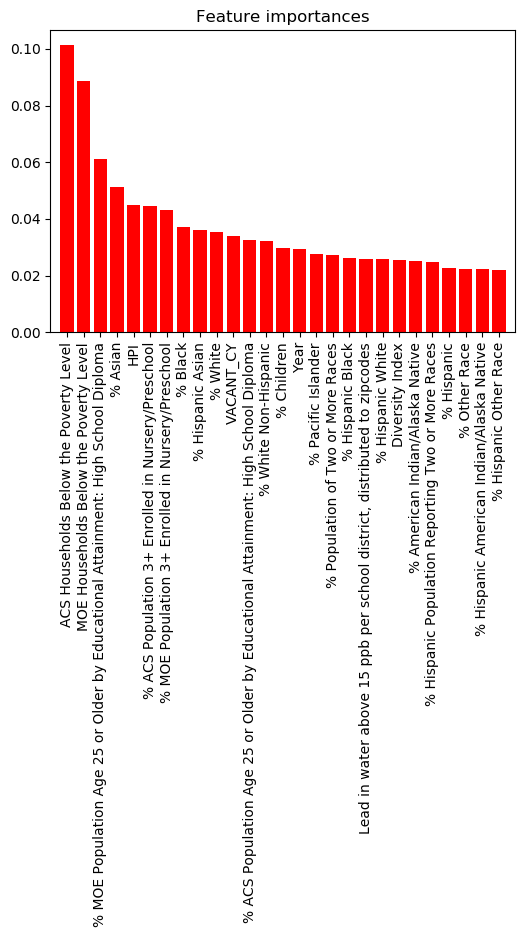

In [14]:
##############################################################################################
#Feature importance analysis
##############################################################################################
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_head = features.columns
feature_head= feature_head[indices][0:35]
# Print the feature ranking
print("Feature ranking:")

X = features.shape[1]
# Plot the impurity-based feature importances of the forest
plt.figure(dpi=100)
plt.title("Feature importances")
plt.bar(range(X), importances[indices][0:X],color="r")
plt.xticks(range(X), feature_head, rotation='vertical')
plt.xlim([-1, X])
plt.show()

In [ ]:
#save feature importance
d = {'feature': feature_head,
     'importance': importances[indices][0:X]
     }
df_feature_importance = pd.DataFrame(d)
df_feature_importance.to_excel('RF feature importance NY.xlsx')

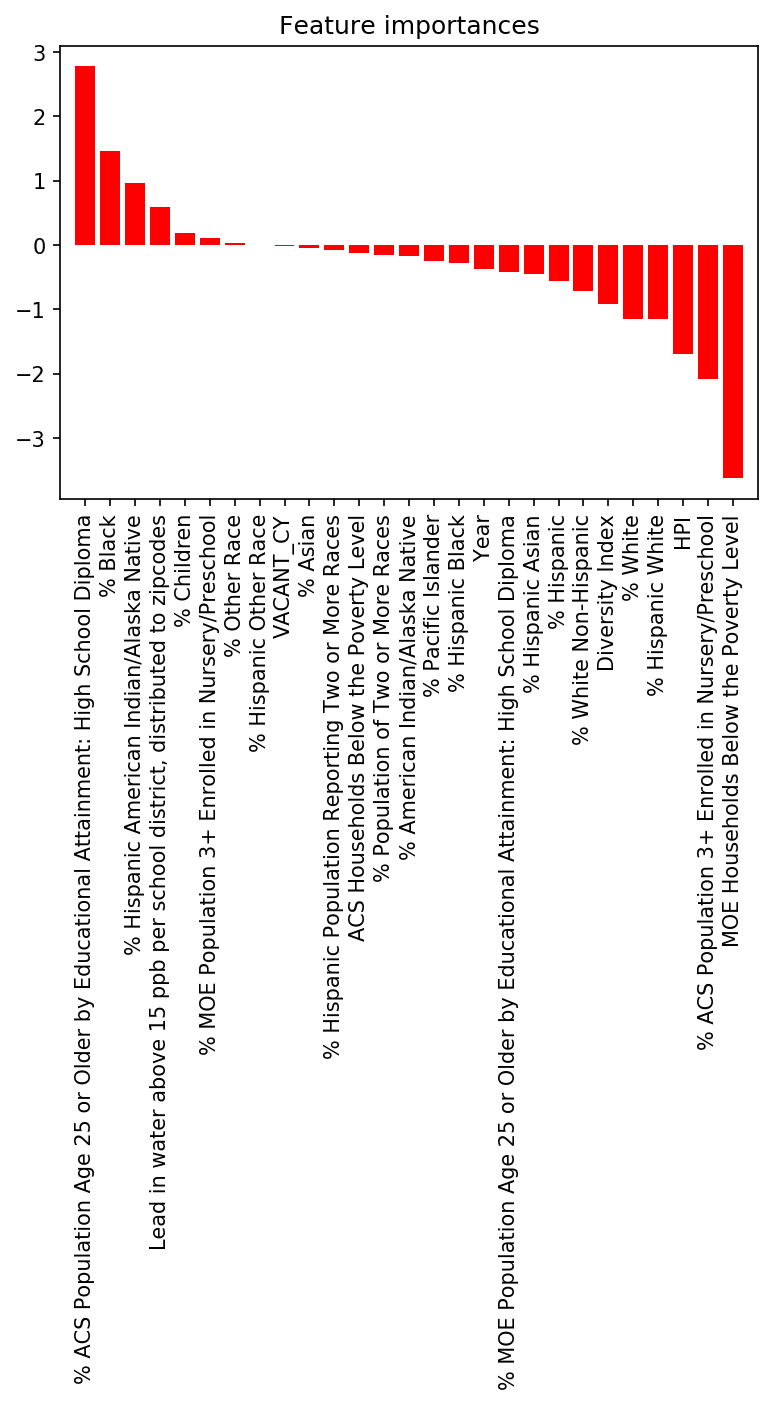

In [15]:
#logit model
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression()
logit_model.fit(features, label.values.ravel())

# Examine the coefficients
importances = logit_model.coef_
importances = np.array(importances)
importances= importances.flatten()
feature_head = features.columns
indices = np.argsort(importances)[::-1]
feature_head= feature_head[indices]

# Plot the logistic regression coefficients
plt.figure(dpi=150)
plt.title("Feature importances")
plt.bar(range(features.shape[1]), importances[indices],
        color="r")
plt.xticks(range(features.shape[1]), feature_head, rotation='vertical')
plt.xlim([-1, features.shape[1]])
plt.show()

Feature_imp_data_log = [feature_head,importances[indices]]
Feature_imp_data_log = np.transpose(Feature_imp_data_log)

Feature_imp_data_log = [feature_head,importances[indices]]
Feature_imp_data_log = np.transpose(Feature_imp_data_log)
Fig_4_df = pd.DataFrame(Feature_imp_data_log, columns = ['Feature','Importance'])
Fig_4_df.to_excel('Pb in blood Fig 4 NY.xlsx')

In [16]:
features, label = shuffle(features,label)
scoring = {'roc_auc': 'roc_auc',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
rfc_cv_score = cross_validate(rf, features, label.values.ravel(), cv=5, scoring=scoring)

#OOB score
rf.fit(features, label.values.ravel())
OOB_score = rf.oob_score_


print("=== All AUC Scores ===")
print(rfc_cv_score['test_roc_auc'])
print('\n')

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score['test_roc_auc'].mean())
print('\n')

print("=== All F1 Scores ===")
print(rfc_cv_score['test_f1'])
print('\n')

print("=== Mean F1 Score ===")
print("Mean F1 Score - Random Forest: ", rfc_cv_score['test_f1'].mean())
print('\n')

print("=== All Precision ===")
print(rfc_cv_score['test_precision'])
print('\n')

print("=== Mean Precision Score ===")
print("Precision Score - Random Forest: ", rfc_cv_score['test_precision'].mean())
print('\n')

print("=== All Recall ===")
print(rfc_cv_score['test_recall'])
print('\n')

print("=== Mean Recall Score ===")
print("Recall Score - Random Forest: ", rfc_cv_score['test_recall'].mean())
print('\n')

print("=== Out of Bag Error ===")
print("OOB Score - Random Forest: ", OOB_score)
print('\n')

=== All AUC Scores ===
[0.87682563 0.84823441 0.88617581 0.92990233 0.90781367]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8897903708539123


=== All F1 Scores ===
[0.76635514 0.61386139 0.66666667 0.78431373 0.74747475]


=== Mean F1 Score ===
Mean F1 Score - Random Forest:  0.715734333191428


=== All Precision ===
[0.78846154 0.67391304 0.72340426 0.85106383 0.84090909]


=== Mean Precision Score ===
Precision Score - Random Forest:  0.7755503515910547


=== All Recall ===
[0.74545455 0.56363636 0.61818182 0.72727273 0.67272727]


=== Mean Recall Score ===
Recall Score - Random Forest:  0.6654545454545454


=== Out of Bag Error ===
OOB Score - Random Forest:  0.8297389330306469




Predicting NYC

In [17]:
features_pred = testing.drop(columns = ['label'])
probs = pd.DataFrame(rf.predict_proba(features_pred)[:,1], columns = ['prob']) #probability of predicting 1 in a DataFrame

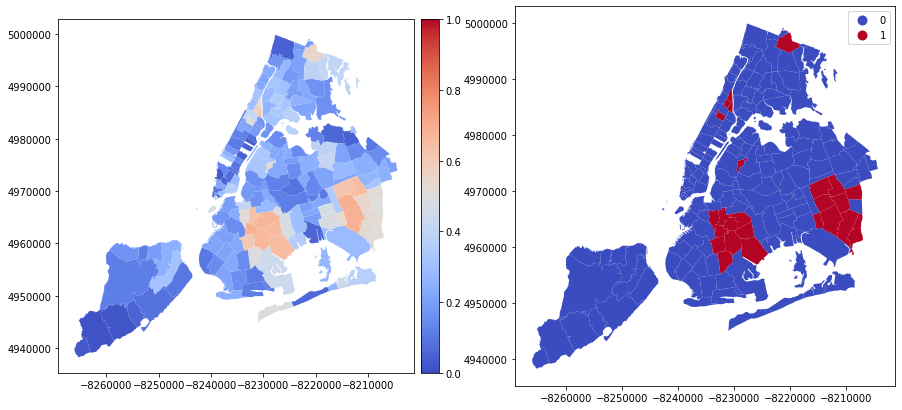

In [30]:
#Plotting prediction
geometry = raw_data[raw_data['label'].isna()][['geometry']] #taking the geometry column for just the testing data
geometrydf = gpd.GeoDataFrame(geometry)
geometrydf['label'] = np.where(probs['prob'] >= 0.5, 1, 0)
geometrydf['prob'] = np.array(probs['prob'])
fig, (ax1, ax2) = plt.subplots(figsize = (15,15), ncols=2)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
geometrydf.plot(ax = ax1, column='prob',legend=True, cmap='coolwarm', figsize=(10, 7), vmin = 0, vmax = 1, cax = cax);
geometrydf.plot(ax = ax2, column='label', legend=True, categorical=True, cmap='coolwarm', figsize=(10, 7), vmin = 0, vmax=1);

In [31]:
#Predicting average lead exposure in NYC
total_child = pd.read_csv('NYC_totalchild.csv') #file created separately with #children for each zipcode (absolute number, unscaled)
percentage_exposed = (probs['prob']*threshold*total_child['total children']).sum()/total_child['total children'].sum()
print('Percentage of children with potentially elevated BLL:', round(percentage_exposed,5) )

Percentage of children with potentially elevated BLL: 0.01735


Get percentage of children exposed by Borough

In [23]:
total_child = pd.read_csv('NYC_totalchild.csv')
total_child['proba'] = probs['prob']
boroughs = pd.read_excel('NYC Boroughs.xlsx')
total_child = total_child.merge(boroughs, left_on='POSTAL', right_on='Zipcode', how='left')
bs = total_child.Borough.unique()
bor = []
exposed_bor = []
for i in bs:
    borough_data = total_child[total_child['Borough']==i]
    borough_exposed = (borough_data['proba']*threshold*borough_data['total children']).sum()/borough_data['total children'].sum()*1000
    bor.append(i)
    exposed_bor.append(borough_exposed)
d = {'borough':bor, 'children exposed per 1000':exposed_bor}
children_exposed_borough = pd.DataFrame(data = d)
children_exposed_borough

,borough,children exposed per 1000
0,Manhattan,13.513638
1,Staten,7.712009
2,Bronx,16.846920
3,Queens,17.932477
4,Brooklyn,20.358399


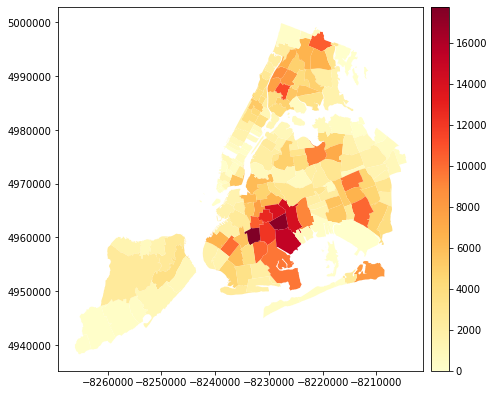

In [35]:
social_cost = probs['prob']*threshold*total_child['total children']*50 #in 1,000 USD
geometry = raw_data[raw_data['label'].isna()][['geometry']] #taking the geometry column for just the testing data
geometrydf = gpd.GeoDataFrame(geometry)
geometrydf['label'] = np.where(probs['prob'] >= 0.5, 1, 0)
geometrydf['prob'] = np.array(social_cost)
fig, (ax1) = plt.subplots(figsize = (7,7), ncols=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
geometrydf.plot(ax = ax1, column='prob',legend=True, cmap='YlOrRd', figsize=(10, 7), vmin = 0, vmax = max(social_cost), cax = cax);

In [36]:
#Calculate total social cost of childhood lead poisoning in NYC (in $1,000)
total_social_cost = (probs['prob']*threshold*total_child['total children']*50).sum()
print(total_social_cost)
children_exposed = (probs['prob']*threshold*total_child['total children']).sum()
print(children_exposed)

606337.3858393498
12126.747716786997
